Your Full Name: 
    
`Arindam Choudhury`

    Nutan Mandale
    
    Humberto Gonzalez Granda

Your Uplevel Email Address:
    
    arindam.choudhury.email@gmail.com
    
    nutan.mandale@gmail.com
    
    HumbertoGonzalezGranda@gmail.com

Name of the Problem Statement of Submission:
    
    ShopTalk (Project-6)

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import os
import requests
from io import BytesIO
from dotenv import load_dotenv
load_dotenv()

/Users/arindam/Machine Learning/GitHub_Repository/ShopChat_APP/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

#### S3 Bucket name

In [2]:
ABO_BUCKET_NAME:     str = os.getenv("ABO_BUCKET_NAME")
YOUR_S3_BUCKET_NAME: str = os.getenv("YOUR_S3_BUCKET_NAME")
ARTIFACTS_FOLDER:    str = os.getenv("ARTIFACTS_FOLDER")
EDA_FOLDER_NAME:     str = os.getenv("EDA_FOLDER_NAME")
image_folder_path    = f"s3://{ABO_BUCKET_NAME}/abo-images-small/images/small/"
image_url_path       = f"https://{ABO_BUCKET_NAME}.s3.amazonaws.com/images/small/"

#### Get the JSON file created in 1.

In [3]:
json_path = f"s3://{YOUR_S3_BUCKET_NAME}/{EDA_FOLDER_NAME}/dataset.json"
dataset = pd.read_json(json_path)
dataset.head(2)

,item_id,product_type,other_image_id,country,marketplace,domain_name,color_code,spin_id,3dmodel_id,brand_in_en_us,...,item_name_in_en_us,item_shape_in_en_us,material_in_en_us,model_name_in_en_us,pattern_in_en_us,product_description_in_en_us,height,width,path,other_image_id_path
0,B0896LJNLH,[{'value': 'DRINKING_CUP'}],"[717gxIR99XL, 51fzW5BNdVL, 21xD1NzxObL]",US,Amazon,amazon.com,None,None,None,AmazonBasics,...,AmazonBasics Serene 16-Piece Old Fashioned and...,None,None,None,None,None,1197,894,07/075e5d67.jpg,"[f2/f24e42d9.jpg, 2d/2da4a5ac.jpg, ed/ed444f23..."
1,B07HCR1LSQ,[{'value': 'EARRING'}],None,JP,Amazon,amazon.co.jp,None,None,None,None,...,[Find] Amazon Collection Platinum Plated Sterl...,None,None,None,None,None,1000,1000,c9/c923418f.jpg,None


#### Use CLIP model to find similarity between image and text

In [4]:
model = SentenceTransformer('clip-ViT-B-32')

##### Lets check for one item in the dataset

In [5]:
index = 12

Item Description: Amazon Brand - Wag Dry Dog Food for Puppies, Chicken and Lentil Recipe (5 lb. Bag) Trial


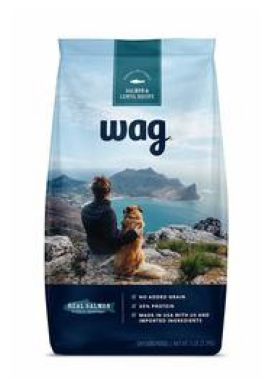

cosine similarity score:  0.3683439791202545


In [6]:
text_embedding  = model.encode(dataset.iloc[index]["item_name_in_en_us"])
image_path      = image_url_path + dataset.iloc[index]["path"]

response = requests.get(image_path)
image_pil = Image.open(BytesIO(response.content)).convert('RGB')

image_embedding = model.encode(image_pil)
cosine = util.cos_sim(image_embedding, text_embedding)

print("Item Description:", dataset.iloc[index]["item_name_in_en_us"])
plt.imshow(image_pil)
plt.axis('off')
plt.show()
print("cosine similarity score: ", cosine.item())

#### Lets do Embedding of images using Clip Model

In [7]:
def images(path):
    image_path = image_url_path + str(path)
    response = requests.get(image_path)
    image_pil = Image.open(BytesIO(response.content)).convert('RGB')
    return image_pil

def embedding(data):
    return model.encode(data)

dataset["image"] = dataset["path"].apply(images)

images = dataset["image"].to_list()
image_embeddings = model.encode(images)

In [8]:
len(images) # how many images are there?

1649

#### Lets try some query and check the score 

[{'corpus_id': 1136, 'score': 0.28400999307632446}, {'corpus_id': 1125, 'score': 0.28400999307632446}, {'corpus_id': 420, 'score': 0.2774706780910492}]
7e/7e4fa60e.jpg


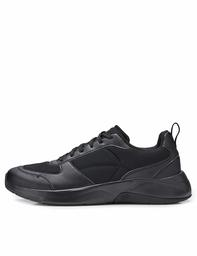

7e/7e4fa60e.jpg


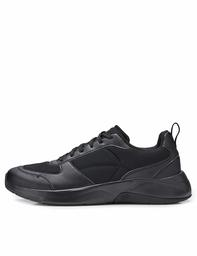

d4/d4495b1d.jpg


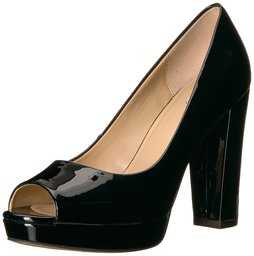

In [9]:
query="black shoes"
query_embedding = model.encode(query)
results = util.semantic_search(query_embedding, image_embeddings, top_k=3)[0]
print(results)
for r in results:
    print(dataset["path"][r['corpus_id']])
    display(images[r['corpus_id']])